# Portfolio Optimization

## Extract Historical Performance

In [36]:
# Import packages
import yfinance as yf
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import scipy.optimize as sci_opt

### Pull from Yahoo Finance package historical data

In [13]:
# List of securities
securities = ['TECB', 'SCHE', 'SCHF', 'SCHV', 'SCHG', 'KOMP', 'MDYG', 'MDYV', 'SLYG', 'SLYV', 'OSMAX', 'USMV', 'SBSPX', 'VOO', '^GSPC']

# Init Dataframe
df = pd.DataFrame()

# Capture the closing price for each security and add to dataframe
for security in securities:
    df[security] = yf.Ticker(security).history(period='max').Close



### EDA

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1052 entries, 2020-01-13 00:00:00-05:00 to 2024-03-18 00:00:00-04:00
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TECB    1052 non-null   float64
 1   SCHE    1052 non-null   float64
 2   SCHF    1052 non-null   float64
 3   SCHV    1052 non-null   float64
 4   SCHG    1052 non-null   float64
 5   KOMP    1052 non-null   float64
 6   MDYG    1052 non-null   float64
 7   MDYV    1052 non-null   float64
 8   SLYG    1052 non-null   float64
 9   SLYV    1052 non-null   float64
 10  OSMAX   1051 non-null   float64
 11  USMV    1052 non-null   float64
 12  SBSPX   1051 non-null   float64
 13  VOO     1052 non-null   float64
 14  ^GSPC   1052 non-null   float64
dtypes: float64(15)
memory usage: 131.5 KB


In [15]:
df.head()

,TECB,SCHE,SCHF,SCHV,SCHG,KOMP,MDYG,MDYV,SLYG,SLYV,OSMAX,USMV,SBSPX,VOO,^GSPC
Date,,,,,,,,,,,,,,,
2020-01-13 00:00:00-05:00,25.037899,25.111067,30.247997,54.255493,47.076683,35.592091,55.274784,50.578262,62.672806,60.318031,39.775181,61.913860,24.353045,282.389893,3288.129883
2020-01-14 00:00:00-05:00,24.954800,24.986490,30.274805,54.354397,46.915195,35.706196,55.361164,50.791714,62.903572,60.559605,39.620792,61.876564,24.318937,282.014923,3283.149902
2020-01-15 00:00:00-05:00,24.999775,24.835220,30.256939,54.354397,47.081570,35.810795,55.485943,50.791714,63.249725,60.708256,39.612667,62.305477,24.361570,282.642944,3289.290039
2020-01-16 00:00:00-05:00,25.245171,24.950899,30.408846,54.785995,47.541527,36.162628,56.023430,51.422791,64.057404,61.544460,39.693920,62.781013,24.566221,285.005219,3316.810059
2020-01-17 00:00:00-05:00,25.345879,25.084375,30.489267,54.875900,47.702995,36.229195,55.965839,51.320694,64.009323,61.330769,39.693920,63.051426,24.660017,285.970825,3329.620117


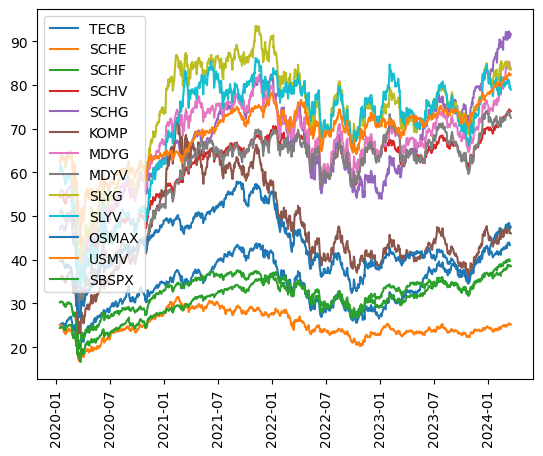

In [16]:
# Plot the close prices
plt.figure()
plt.plot(df.iloc[:,:-2]) # Excluded S&P 500 because of scale
plt.legend(securities)
plt.xticks(rotation=90)
plt.show()

### Correlations

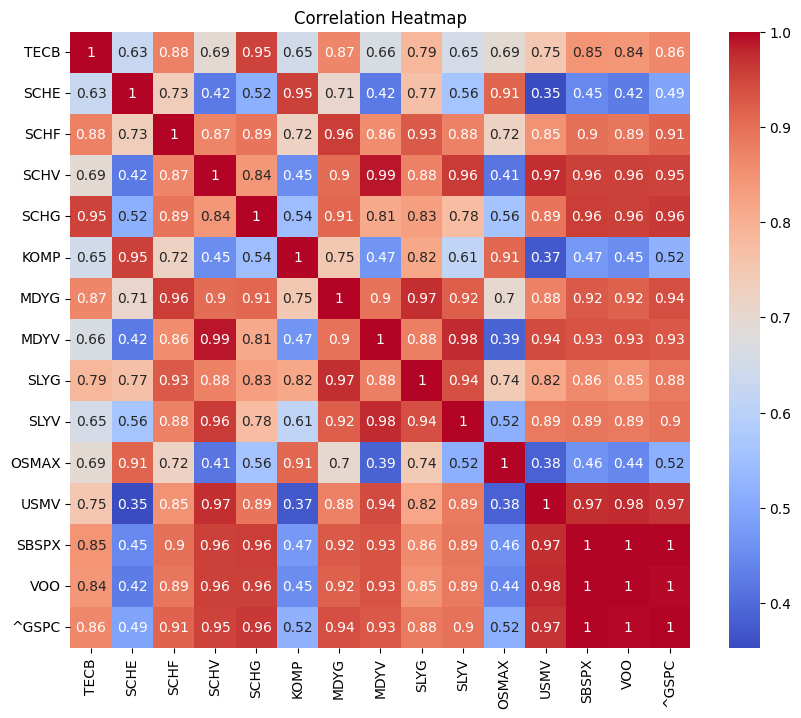

In [17]:
# Measure the correlation
import seaborn as sns

# Create a correlation matrix
corr_matrix = df.corr()

# Set the figure size
plt.figure(figsize=(10, 8))

# Create a heatmap using the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Set the title of the plot
plt.title('Correlation Heatmap')

# Show the plot
plt.show()



In [18]:
df.describe()

,TECB,SCHE,SCHF,SCHV,SCHG,KOMP,MDYG,MDYV,SLYG,SLYV,OSMAX,USMV,SBSPX,VOO,^GSPC
count,1052.000000,1052.000000,1052.000000,1052.000000,1052.000000,1052.000000,1052.000000,1052.000000,1052.000000,1052.000000,1051.000000,1052.000000,1051.000000,1052.000000,1052.000000
mean,34.195066,24.955983,32.630257,61.029348,65.545239,46.709696,66.936935,59.980337,73.911080,70.271343,43.093789,68.947283,30.536277,358.105509,4021.523347
std,5.894237,2.880798,3.727435,7.938413,11.453362,10.314709,9.188957,10.498263,11.219007,12.581507,6.453961,6.654267,4.456618,53.856016,553.823074
min,19.442528,16.622068,19.927042,34.527847,33.855476,23.144844,34.608883,27.822203,38.434227,33.444881,26.749723,43.460915,16.619076,192.386734,2237.399902
25%,29.629408,23.334658,30.040238,56.990707,58.217930,40.127873,62.622008,55.641236,69.584034,67.195854,38.819574,64.349813,28.119187,329.224632,3721.854980
50%,34.197245,24.170000,33.705858,64.011974,65.103111,43.586525,68.529297,64.038235,75.320724,74.913319,41.509998,70.752377,31.380630,367.550598,4119.395020
75%,38.138030,27.593263,35.596447,66.295897,74.331131,54.946668,73.682663,66.644766,82.814785,79.325804,47.615648,73.390825,33.737755,396.757149,4423.822388
max,48.419998,31.504097,38.810001,74.459999,92.260002,72.573456,85.449997,74.110001,93.537994,86.163307,57.892090,82.760002,40.130001,475.029999,5175.270020


## Calculate Sharpe Ratios

In [19]:
# Calculate Daily Simple returns
daily_simple_returns = df.pct_change()

daily_simple_returns


C:\Users\sean1\AppData\Local\Temp\ipykernel_39460\3555513728.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_simple_returns = df.pct_change()


,TECB,SCHE,SCHF,SCHV,SCHG,KOMP,MDYG,MDYV,SLYG,SLYV,OSMAX,USMV,SBSPX,VOO,^GSPC
Date,,,,,,,,,,,,,,,
2020-01-13 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14 00:00:00-05:00,-0.003319,-0.004961,0.000886,0.001823,-0.003430,0.003206,0.001563,0.004220,0.003682,0.004005,-0.003882,-0.000602,-0.001401,-0.001328,-0.001515
2020-01-15 00:00:00-05:00,0.001802,-0.006054,-0.000590,0.000000,0.003546,0.002929,0.002254,0.000000,0.005503,0.002455,-0.000205,0.006932,0.001753,0.002227,0.001870
2020-01-16 00:00:00-05:00,0.009816,0.004658,0.005021,0.007940,0.009769,0.009825,0.009687,0.012425,0.012770,0.013774,0.002051,0.007632,0.008401,0.008358,0.008367
2020-01-17 00:00:00-05:00,0.003989,0.005350,0.002645,0.001641,0.003396,0.001841,-0.001028,-0.001985,-0.000751,-0.003472,0.000000,0.004307,0.003818,0.003388,0.003862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-12 00:00:00-04:00,0.018939,0.009520,0.007794,0.002293,0.017648,0.002134,0.009649,0.000677,-0.000592,-0.005917,0.010795,0.004125,0.011086,0.010702,0.011202
2024-03-13 00:00:00-04:00,-0.006485,-0.003929,0.000516,0.002153,-0.004010,-0.000639,0.005427,0.001895,0.002607,0.000124,-0.006135,-0.001329,-0.001744,-0.001516,-0.001925
2024-03-14 00:00:00-04:00,-0.007878,-0.004734,-0.007472,-0.006581,0.000109,-0.018534,-0.010092,-0.014322,-0.012411,-0.016739,-0.007316,-0.003509,-0.002746,-0.002193,-0.002871


In [54]:
# Calcuate the annualized returns
annualized_returns = daily_simple_returns.mean() * 252 # 252 is the average number of trading days in a year

# Calculate the Standard Deviation
risk_std = daily_simple_returns.std() * np.sqrt(252)


# Calculate the Sharpe Ratio
sharpe_ratio = annualized_returns / risk_std


print(annualized_returns)
print(risk_std)
print(sharpe_ratio)
print("\n")
#print(tabulate([['Stock', 'Cumulative Return (%)', 'Standard Deviation (%)', 'Sharpe Ratio'], pd.DataFrame(annualized_returns.index, annualized_returns, risk_std, sharpe_ratio)], headers='firstrow'))


TECB     0.191439
SCHE     0.026536
SCHF     0.079995
SCHV     0.098484
SCHG     0.195983
KOMP     0.108495
MDYG     0.134822
MDYV     0.126606
SLYG     0.109032
SLYV     0.110380
OSMAX    0.043309
USMV     0.086529
SBSPX    0.142828
VOO      0.149333
^GSPC    0.133322
dtype: float64
TECB     0.274902
SCHE     0.226643
SCHF     0.209328
SCHV     0.218559
SCHG     0.268436
KOMP     0.305270
MDYG     0.263249
MDYV     0.282581
SLYG     0.282902
SLYV     0.302168
OSMAX    0.212564
USMV     0.189565
SBSPX    0.226129
VOO      0.226002
^GSPC    0.226391
dtype: float64
TECB     0.696390
SCHE     0.117084
SCHF     0.382151
SCHV     0.450607
SCHG     0.730093
KOMP     0.355405
MDYG     0.512148
MDYV     0.448034
SLYG     0.385406
SLYV     0.365292
OSMAX    0.203744
USMV     0.456459
SBSPX    0.631624
VOO      0.660758
^GSPC    0.588903
dtype: float64




In [63]:
simulations_data = [annualized_returns, risk_std, sharpe_ratio]

# Create a DataFrame from it, then Transpose it so it looks like our original one.
simulations_df = pd.DataFrame(data=simulations_data).T

# Give the columns the Proper Names.
simulations_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio'
]

# Make sure the data types are correct, we don't want our floats to be strings.
simulations_df = simulations_df.infer_objects()

# Print out the results.
print('')
print('='*80)
print('SIMULATIONS RESULT:')
print('-'*80)
print(simulations_df)
print('-'*80)


SIMULATIONS RESULT:
--------------------------------------------------------------------------------
        Returns  Volatility  Sharpe Ratio
TECB   0.191439    0.274902      0.696390
SCHE   0.026536    0.226643      0.117084
SCHF   0.079995    0.209328      0.382151
SCHV   0.098484    0.218559      0.450607
SCHG   0.195983    0.268436      0.730093
KOMP   0.108495    0.305270      0.355405
MDYG   0.134822    0.263249      0.512148
MDYV   0.126606    0.282581      0.448034
SLYG   0.109032    0.282902      0.385406
SLYV   0.110380    0.302168      0.365292
OSMAX  0.043309    0.212564      0.203744
USMV   0.086529    0.189565      0.456459
SBSPX  0.142828    0.226129      0.631624
VOO    0.149333    0.226002      0.660758
^GSPC  0.133322    0.226391      0.588903
--------------------------------------------------------------------------------


In [67]:
# Return the Max Sharpe Ratio from the run.
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]

# Return the Min Volatility from the run.
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]

# S&P 500 Metrics
sp500 = simulations_df.loc[simulations_df.index=='^GSPC']

print('')
print('='*80)
print('MAX SHARPE RATIO:')
print('-'*80)
print(max_sharpe_ratio)
print('-'*80)

print('')
print('='*80)
print('MIN VOLATILITY:')
print('-'*80)
print(min_volatility)
print('-'*80)

print('')
print('='*80)
print('S&P 500:')
print('-'*80)
print(sp500)
print('-'*80)




MAX SHARPE RATIO:
--------------------------------------------------------------------------------
Returns         0.195983
Volatility      0.268436
Sharpe Ratio    0.730093
Name: SCHG, dtype: float64
--------------------------------------------------------------------------------

MIN VOLATILITY:
--------------------------------------------------------------------------------
Returns         0.086529
Volatility      0.189565
Sharpe Ratio    0.456459
Name: USMV, dtype: float64
--------------------------------------------------------------------------------

S&P 500:
--------------------------------------------------------------------------------
        Returns  Volatility  Sharpe Ratio
^GSPC  0.133322    0.226391      0.588903
--------------------------------------------------------------------------------


C:\Users\sean1\AppData\Local\Temp\ipykernel_39460\1082289826.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[1],
C:\Users\sean1\AppData\Local\Temp\ipykernel_39460\1082289826.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[0],
C:\Users\sean1\AppData\Local\Temp\ipykernel_39460\1082289826.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(max_sharpe_ratio[1],
C:\Users\sean1\AppData

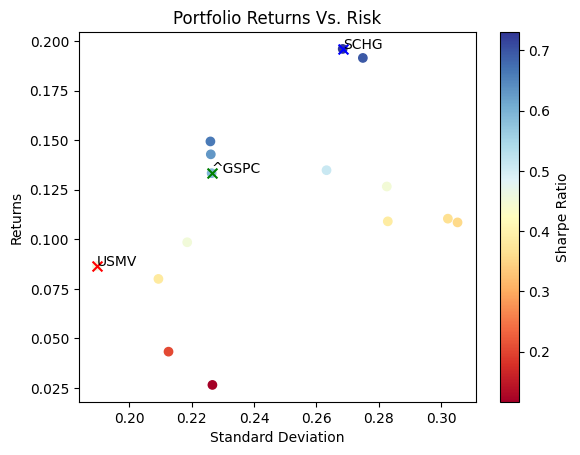

In [94]:
# Risk & Return Graph
plt.scatter(y=annualized_returns, x=risk_std, c=sharpe_ratio, cmap='RdYlBu')

# Give the Plot some labels, and titles.
plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

# Plot the Max Sharpe Ratio, using a `Red Star`.
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker="x",
    color='b',
    s=50
)
plt.text(max_sharpe_ratio[1],
    max_sharpe_ratio[0],max_sharpe_ratio.name)


# Plot the Min Volatility, using a `Blue Star`.
plt.scatter(
    min_volatility[1],
    min_volatility[0],
    marker="x",
    color='r',
    s=50
)
plt.text(min_volatility[1],
    min_volatility[0],min_volatility.name)

# Plot the S&P 500, using a `Green Star`.
plt.scatter(
    sp500.iloc[:,1],
    sp500.iloc[:,0],
    marker='x',
    color='g',
    s=50
)
plt.text(sp500.iloc[:,1],
    sp500.iloc[:,0],sp500.index.values[0])

# Finally, show the plot.
plt.show()

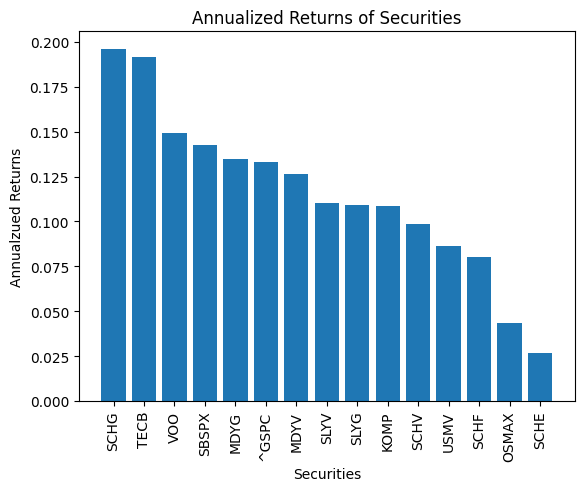

In [21]:
# Sort descending
annualized_returns = annualized_returns.sort_values(ascending=False)

# Plot
plt.bar(annualized_returns.index, annualized_returns)
plt.ylabel('Annualzued Returns')
plt.xlabel('Securities')
plt.title('Annualized Returns of Securities')
plt.xticks(rotation = 90)
plt.show()

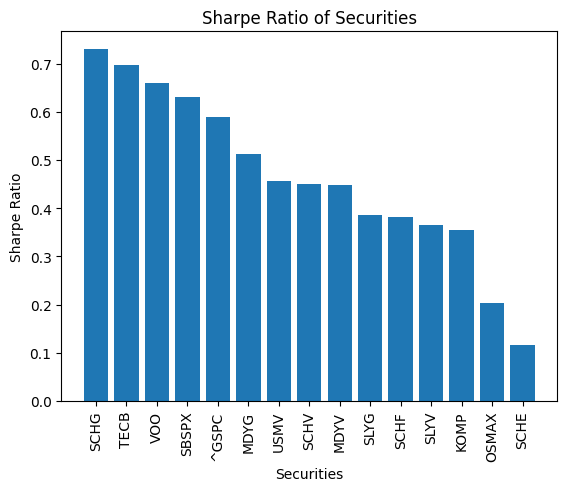

In [22]:
# Sort descending
sharpe_ratio = sharpe_ratio.sort_values(ascending=False)

# Plot
plt.bar(sharpe_ratio.index, sharpe_ratio)
plt.ylabel('Sharpe Ratio')
plt.xlabel('Securities')
plt.title('Sharpe Ratio of Securities')
plt.xticks(rotation = 90)
plt.show()

## Calculate Portfolio Expected Value
This code is from [Sigma Coding](https://www.youtube.com/c/SigmaCoding).
https://github.com/areed1192/portfolio-optimization.git

In [35]:
# Define portfolio only with ETFs
symbols = ['TECB', 'SCHE', 'SCHF', 'SCHV', 'SCHG', 'KOMP', 'MDYG', 'MDYV', 'SLYG', 'SLYV', 'OSMAX', 'USMV', 'VOO']
price_data_frame = df[symbols]

# of symbols we have, so let's save some time and just calculate that now.
number_of_symbols = len(symbols)
print(f'The portfolio has {number_of_symbols} ETFs to select from.')



The portfolio has 13 ETFs to select from.


In [41]:
# Calculate the Log of returns.
#log_return = np.log(1 + price_data_frame.pct_change())
log_return = price_data_frame.pct_change() # Test without log

# Generate Random Weights.
random_weights = np.array(np.random.random(number_of_symbols))

# Generate the Rebalance Weights, these should equal 1.
rebalance_weights = random_weights / np.sum(random_weights)

# Calculate the Expected Returns, annualize it by multiplying it by `252`.
exp_ret = np.sum((log_return.mean() * rebalance_weights) * 252)

# Calculate the Expected Volatility, annualize it by multiplying it by `252`.
exp_vol = np.sqrt(
np.dot(
    rebalance_weights.T,
    np.dot(
        log_return.cov() * 252,
        rebalance_weights
    )
)
)

# Calculate the Sharpe Ratio.
sharpe_ratio = exp_ret / exp_vol

# Put the weights into a data frame to see them better.
weights_df = pd.DataFrame(data={
'random_weights': random_weights,
'rebalance_weights': rebalance_weights
})
print('')
print('='*80)
print('PORTFOLIO WEIGHTS:')
print('-'*80)
print(weights_df)
print('-'*80)

# Do the same with the other metrics.
metrics_df = pd.DataFrame(data={
    'Expected Portfolio Returns': exp_ret,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])

print('')
print('='*80)
print('PORTFOLIO METRICS:')
print('-'*80)
print(metrics_df)
print('-'*80)


PORTFOLIO WEIGHTS:
--------------------------------------------------------------------------------
    random_weights  rebalance_weights
0         0.966445           0.125949
1         0.857506           0.111752
2         0.764701           0.099657
3         0.971808           0.126648
4         0.186338           0.024284
5         0.319575           0.041648
6         0.790575           0.103029
7         0.384422           0.050099
8         0.591777           0.077122
9         0.581017           0.075719
10        0.504689           0.065772
11        0.542751           0.070732
12        0.211693           0.027588
--------------------------------------------------------------------------------

PORTFOLIO METRICS:
--------------------------------------------------------------------------------
   Expected Portfolio Returns  Expected Portfolio Volatility  \
0                    0.106889                       0.224899   

   Portfolio Sharpe Ratio  
0                0.475274  


C:\Users\sean1\AppData\Local\Temp\ipykernel_39460\2352309561.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  log_return = price_data_frame.pct_change() # Test without log


## Portfolio Optimization

### Monte Carlo

In [108]:
# Initialize the components, to run a Monte Carlo Simulation.

# We will run 5000 iterations.
num_of_portfolios = 5000

# Prep an array to store the weights as they are generated, 5000 iterations for each of our 4 symbols.
all_weights = np.zeros((num_of_portfolios, number_of_symbols))

# Prep an array to store the returns as they are generated, 5000 possible return values.
ret_arr = np.zeros(num_of_portfolios)

# Prep an array to store the volatilities as they are generated, 5000 possible volatility values.
vol_arr = np.zeros(num_of_portfolios)

# Prep an array to store the sharpe ratios as they are generated, 5000 possible Sharpe Ratios.
sharpe_arr = np.zeros(num_of_portfolios)

# Start the simulations.
for ind in range(num_of_portfolios):

    # First, calculate the weights.
    weights = np.array(np.random.random(number_of_symbols))
    weights = weights / np.sum(weights)

    # Add the weights, to the `weights_arrays`.
    all_weights[ind, :] = weights

    # Calculate the expected log returns, and add them to the `returns_array`.
    ret_arr[ind] = np.sum((log_return.mean() * weights) * 252)

    # Calculate the volatility, and add them to the `volatility_array`.
    vol_arr[ind] = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio and Add it to the `sharpe_ratio_array`.
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

# Let's create our "Master Data Frame", with the weights, the returns, the volatility, and the Sharpe Ratio
simulations_data = [ret_arr, vol_arr, sharpe_arr, all_weights]

# Create a DataFrame from it, then Transpose it so it looks like our original one.
simulations_df = pd.DataFrame(data=simulations_data).T

# Give the columns the Proper Names.
simulations_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',
    'Portfolio Weights'
]

# Make sure the data types are correct, we don't want our floats to be strings.
simulations_df = simulations_df.infer_objects()

# Print out the results.
print('')
print('='*80)
print('SIMULATIONS RESULT:')
print('-'*80)
print(simulations_df.head())
print('-'*80)


SIMULATIONS RESULT:
--------------------------------------------------------------------------------
    Returns  Volatility  Sharpe Ratio  \
0  0.104054    0.219897      0.473197   
1  0.110551    0.231482      0.477578   
2  0.114571    0.231312      0.495308   
3  0.111377    0.229775      0.484723   
4  0.117449    0.229664      0.511395   

                                   Portfolio Weights  
0  [0.045115335324777794, 0.05750976389897944, 0....  
1  [0.057100611638160895, 0.10257836627550761, 0....  
2  [0.0429876535057667, 0.01729635148766975, 0.04...  
3  [0.06166522540987149, 0.035628723189823366, 0....  
4  [0.13450389293832157, 0.00942947886361972, 0.0...  
--------------------------------------------------------------------------------


In [117]:
# Return the Max Sharpe Ratio from the run.
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]


# Return the Min Volatility from the run.
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]

print('')
print('='*80)
print('MAX SHARPE RATIO:')
print('-'*80)
print(max_sharpe_ratio)
print('-'*80)

print('')
print('='*80)
print('MIN VOLATILITY:')
print('-'*80)
print(min_volatility)
print('-'*80)


MAX SHARPE RATIO:
--------------------------------------------------------------------------------
Returns                                                       0.144912
Volatility                                                    0.240229
Sharpe Ratio                                                  0.603221
Portfolio Weights    [0.19010374668792945, 0.026469481494871577, 0....
Scenario                                        Monte Carlo Max Sharpe
Name: 4403, dtype: object
--------------------------------------------------------------------------------

MIN VOLATILITY:
--------------------------------------------------------------------------------
Returns                                                       0.092616
Volatility                                                    0.209494
Sharpe Ratio                                                  0.442094
Portfolio Weights    [0.11300210866885194, 0.1331843139645408, 0.11...
Scenario                                    Monte Carlo 

C:\Users\sean1\AppData\Local\Temp\ipykernel_39460\1640801727.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_sharpe_ratio['Scenario'] = 'Monte Carlo Max Sharpe'
C:\Users\sean1\AppData\Local\Temp\ipykernel_39460\1640801727.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_sharpe_ratio['Scenario'] = 'Monte Carlo Max Sharpe'
C:\Users\sean1\AppData\Local\Temp\ipykernel_39460\1640801727.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

C:\Users\sean1\AppData\Local\Temp\ipykernel_39460\563608600.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[1],
C:\Users\sean1\AppData\Local\Temp\ipykernel_39460\563608600.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[0],
C:\Users\sean1\AppData\Local\Temp\ipykernel_39460\563608600.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_volatility[1],
C:\Users\sean1\AppData\Local\Temp\ip

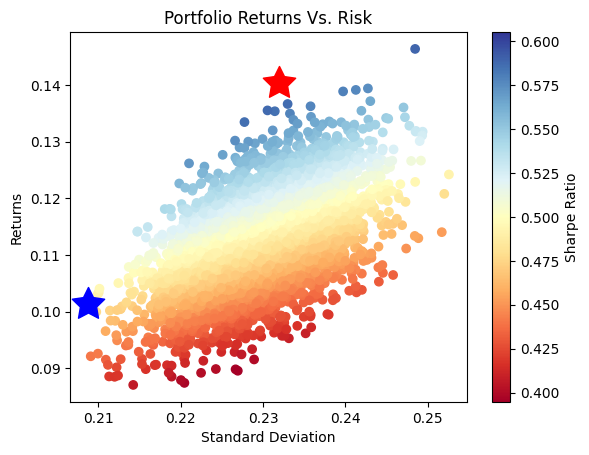

In [44]:
# This is so I can see the plot inside of my Jupyter Notebook.
%matplotlib inline

# Plot the data on a Scatter plot.
plt.scatter(
    y=simulations_df['Returns'],
    x=simulations_df['Volatility'],
    c=simulations_df['Sharpe Ratio'],
    cmap='RdYlBu'
)

# Give the Plot some labels, and titles.
plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

# Plot the Max Sharpe Ratio, using a `Red Star`.
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker=(5, 1, 0),
    color='r',
    s=600
)

# Plot the Min Volatility, using a `Blue Star`.
plt.scatter(
    min_volatility[1],
    min_volatility[0],
    marker=(5, 1, 0),
    color='b',
    s=600
)

# Finally, show the plot.
plt.show()

### Scipy Optimization

In [96]:
def get_metrics(weights: list) -> np.array:
    """
    ### Overview:
    ----
    With a given set of weights, return the portfolio returns,
    the portfolio volatility, and the portfolio sharpe ratio.

    ### Arguments:
    ----
    weights (list): An array of portfolio weights.

    ### Returns:
    ----
    (np.array): An array containg return value, a volatility value,
        and a sharpe ratio.
    """

    # Convert to a Numpy Array.
    weights = np.array(weights)

    # Calculate the returns, remember to annualize them (252).
    ret = np.sum(log_return.mean() * weights) * 252

    # Calculate the volatility, remember to annualize them (252).
    vol = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio.
    sr = ret / vol

    return np.array([ret, vol, sr])

def grab_negative_sharpe(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[2] * -1

def grab_volatility(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[1]

def check_sum(weights: list) -> float:
    """Ensure the allocations of the "weights", sums to 1 (100%)

    ### Arguments:
    ----
    weights (list): The weights we want to check to see
        if they sum to 1.

    ### Returns:
    ----
    float: The different between 1 and the sum of the weights.
    """
    return np.sum(weights) - 1

In [97]:
# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(number_of_symbols))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with,
# and usually the best initial guess is just an
# even distribution. In this case 25% for each of the 4 stocks.
init_guess = number_of_symbols * [1 / number_of_symbols]

# Perform the operation to minimize the risk.
optimized_sharpe = sci_opt.minimize(
    grab_negative_sharpe, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED SHARPE RATIO:')
print('-'*80)
print(optimized_sharpe)
print('-'*80)


OPTIMIZED SHARPE RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.7300932375793868
       x: [ 0.000e+00  1.370e-16 ...  0.000e+00  0.000e+00]
     nit: 9
     jac: [ 1.175e-02  3.550e-01 ...  1.094e-01  2.691e-02]
    nfev: 126
    njev: 9
--------------------------------------------------------------------------------


In [149]:
# Grab the metrics.
optimized_max_sharpe_metrics = get_metrics(weights=optimized_sharpe.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_sharpe.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_max_sharpe_metrics)
print('-'*80)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[0.00000000e+00 1.37043155e-16 0.00000000e+00 0.00000000e+00
 1.00000000e+00 3.29597460e-17 1.37043155e-16 0.00000000e+00
 0.00000000e+00 3.29597460e-17 4.51028104e-17 0.00000000e+00
 0.00000000e+00]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[0.19598327 0.26843595 0.73009324]
--------------------------------------------------------------------------------


In [48]:
# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(number_of_symbols))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with,
# and usually the best initial guess is just an
# even distribution. In this case 25% for each of the 4 stocks.
init_guess = number_of_symbols * [1 / number_of_symbols]

# Perform the operation to minimize the risk.
optimized_volatility = sci_opt.minimize(
    grab_volatility, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED VOLATILITY RATIO:')
print('-'*80)
print(optimized_volatility)
print('-'*80)


OPTIMIZED VOLATILITY RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.1832700009892283
       x: [ 0.000e+00  1.428e-01 ...  6.583e-01  0.000e+00]
     nit: 15
     jac: [ 2.285e-01  1.830e-01 ...  1.834e-01  2.169e-01]
    nfev: 210
    njev: 15
--------------------------------------------------------------------------------


In [150]:
# Grab the metrics.
optimized_min_volatility_metrics = get_metrics(weights=optimized_volatility.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_volatility.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_min_volatility_metrics)
print('-'*80)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[0.00000000e+00 1.42849187e-01 1.78635382e-18 0.00000000e+00
 2.65058945e-17 8.50497479e-17 1.56336227e-17 3.41736941e-17
 1.65927004e-17 0.00000000e+00 1.98899498e-01 6.58251316e-01
 0.00000000e+00]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[0.06936232 0.18327    0.37847067]
--------------------------------------------------------------------------------


## Evaluate Scenarios

In [157]:
# List the scenarios
scenarios = ['Monte Carlo Min Volatility', 'Monte Carlo Max Sharpe', 'Scipy Max Sharpe', 'Scipy Min Volatility']

# Combine all the scenarios into one dataframe for summary
df_portfolio_metrics_scenarios = pd.DataFrame([max_sharpe_ratio[:3].values, min_volatility[:3].values, optimized_max_sharpe_metrics, optimized_min_volatility_metrics], index=scenarios, columns=simulations_df.columns[:3]).reset_index().rename(columns={'index' : 'Scenario'})
df_portfolio_weights_scenarios = pd.DataFrame([max_sharpe_ratio[3], min_volatility[3], optimized_sharpe.x, optimized_volatility.x], columns=symbols, index=scenarios).reset_index().rename(columns={'index' : 'Scenario'})
df_portfolio_metrics_scenarios = df_portfolio_metrics_scenarios.merge(df_portfolio_weights_scenarios, on='Scenario')


print(df_portfolio_metrics_scenarios)

                     Scenario   Returns  Volatility  Sharpe Ratio      TECB  \
0      Monte Carlo Max Sharpe  0.144912    0.240229      0.603221  0.190104   
1  Monte Carlo Min Volatility  0.092616    0.209494      0.442094  0.113002   
2            Scipy Max Sharpe  0.195983    0.268436      0.730093  0.000000   
3        Scipy Min Volatility  0.069362    0.183270      0.378471  0.000000   

           SCHE          SCHF      SCHV          SCHG          KOMP  \
0  2.646948e-02  1.016563e-02  0.078285  1.499117e-01  1.045808e-02   
1  1.331843e-01  1.189179e-01  0.081964  1.385174e-02  6.862312e-02   
2  1.370432e-16  0.000000e+00  0.000000  1.000000e+00  3.295975e-17   
3  1.428492e-01  1.786354e-18  0.000000  2.650589e-17  8.504975e-17   

           MDYG          MDYV          SLYG          SLYV         OSMAX  \
0  1.964628e-01  1.143066e-01  3.624330e-02  1.177269e-02  2.556392e-02   
1  2.423144e-02  2.613807e-02  2.451460e-02  2.585270e-02  1.572006e-01   
2  1.370432e-16  0.0000

C:\Users\sean1\AppData\Local\Temp\ipykernel_39460\407935015.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scenarios = [max_sharpe_ratio[4], min_volatility[4], 'Scipy Max Sharpe', 'Scipy Min Volatility']
C:\Users\sean1\AppData\Local\Temp\ipykernel_39460\407935015.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_portfolio_weights_scenarios = pd.DataFrame([max_sharpe_ratio[3], min_volatility[3], optimized_sharpe.x, optimized_volatility.x], columns=symbols, index=scenarios).reset_index().rename(columns={'index' : 'Scenario'})


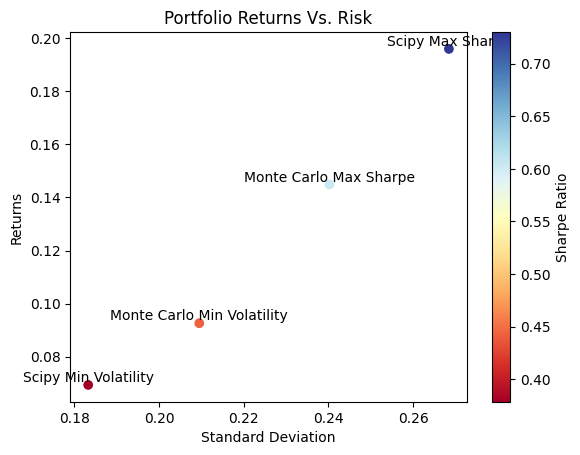

In [171]:
# Plot the Scenarios Risk and Rewards

plt.scatter(data=df_portfolio_metrics_scenarios, x='Volatility', y='Returns', c='Sharpe Ratio', cmap='RdYlBu')


for index, row in df_portfolio_metrics_scenarios.iterrows():
    plt.text(row['Volatility'], row['Returns'], row['Scenario'], va='bottom', ha='center')    

# Give the Plot some labels, and titles.
plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.show()

In [173]:
df_portfolio_weights_scenarios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Scenario  4 non-null      object 
 1   TECB      4 non-null      float64
 2   SCHE      4 non-null      float64
 3   SCHF      4 non-null      float64
 4   SCHV      4 non-null      float64
 5   SCHG      4 non-null      float64
 6   KOMP      4 non-null      float64
 7   MDYG      4 non-null      float64
 8   MDYV      4 non-null      float64
 9   SLYG      4 non-null      float64
 10  SLYV      4 non-null      float64
 11  OSMAX     4 non-null      float64
 12  USMV      4 non-null      float64
 13  VOO       4 non-null      float64
dtypes: float64(13), object(1)
memory usage: 580.0+ bytes


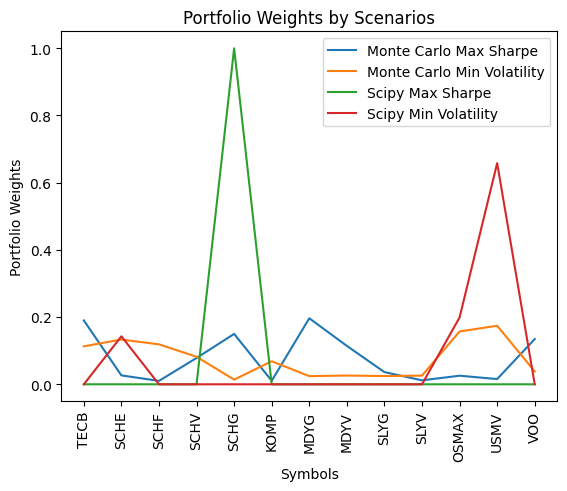

In [192]:
# Plot the Weights for each scenario

plt.plot(df_portfolio_weights_scenarios.iloc[:,1:].T)
plt.title('Portfolio Weights by Scenarios')
plt.xlabel('Symbols')
plt.ylabel('Portfolio Weights')
plt.xticks(rotation=90)
plt.legend(scenarios)
plt.show()
